# Imports

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Gillespies Algorithm

In [2]:
def run_sir_simulation(beta, gamma, mu, N, infected_init, recovered_init, max_time=60, random_seed=None):

    if random_seed is not None:
        random.seed(random_seed)
        np.random.seed(random_seed)
        
    # Initialize compartments
    X = N - infected_init - recovered_init
    Y = infected_init
    Z = recovered_init

    # Define events
    def Birth(X):
        X += 1
        return X

    def GetInfected(X, Y):
        Y += 1
        X -= 1
        return X, Y

    def Recover(Y, Z):
        Y -= 1
        Z += 1
        return Y, Z

    def DieSusceptible(X):
        X -= 1
        return X

    def DieInfected(Y):
        Y -= 1
        return Y

    def DieRecovered(Z):
        Z -= 1
        return Z

    # Define event chance
# Define event chance
    def GetNextEventTime(event_rate):
        if event_rate > 0:
            delta_t = (-1 / event_rate) * (np.log(random.uniform(0, 1)))
            return delta_t
        else:
            return float('inf')  # Set a large value for next event time if event rate is zero

    def GetRates(X, Y, Z, N, beta, gamma, mu):
        birth_rate = mu * N
        transmission_rate = beta * ((X * Y) / N)
        recovery_rate = gamma * Y
        X_death_rate = mu * X
        Y_death_rate = mu * Y
        Z_death_rate = mu * Z
        return [birth_rate, transmission_rate, recovery_rate, X_death_rate, Y_death_rate, Z_death_rate]

    # Initialize simulation
    data = []
    time = 0

    while time < max_time:
        rates = GetRates(X, Y, Z, N, beta, gamma, mu)

        # Store data
        data.append([time, X, Y, Z])
        next_event_times = []

        for rate in rates:
            next_event_times.append(GetNextEventTime(rate))

        next_event_time = min(next_event_times)
        index_next_event = next_event_times.index(next_event_time)

        time += next_event_time

        # Choose event to execute according to minimal delta_t
        if index_next_event == 0:
            X = Birth(X)
        elif index_next_event == 1:
            X, Y = GetInfected(X, Y)
        elif index_next_event == 2:
            Y, Z = Recover(Y, Z)
        elif index_next_event == 3:
            X = DieSusceptible(X)
        elif index_next_event == 4:
            Y = DieInfected(Y)
        else:
            Z = DieRecovered(Z)

        N = X + Y + Z  # Update N

    # Extract data
    time_series = [entry[0] for entry in data]
    X_series = [entry[1] for entry in data]
    Y_series = [entry[2] for entry in data]
    Z_series = [entry[3] for entry in data]

    return time_series, X_series, Y_series, Z_series

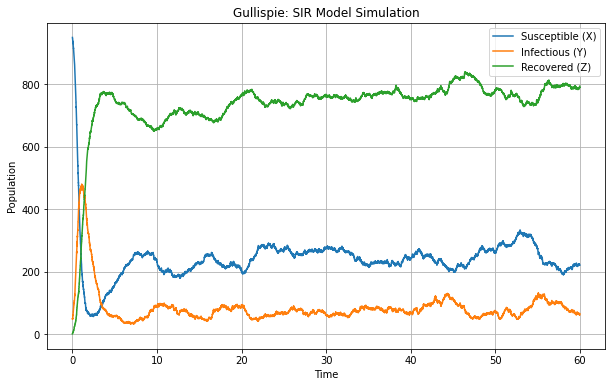

In [5]:
# Example usage of the function
beta = 5
gamma = 1
mu = 0.1
N = 1000
infected_init = 49
recovered_init = 1
max_time = 60

time_series, X_series, Y_series, Z_series = run_sir_simulation(beta, gamma, mu, N, infected_init, recovered_init, max_time)

#Plot
plt.figure(figsize=(10, 6))
plt.plot(time_series, X_series, label='Susceptible (X)')
plt.plot(time_series, Y_series, label='Infectious (Y)')
plt.plot(time_series, Z_series, label='Recovered (Z)')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Gullispie: SIR Model Simulation')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# First Experiment - Changing Seeding

In [6]:
# Run the simulation with different random seeds
random_seeds = [42, 123, 987, 456, 789]  # You can change these values
simulation_results = []

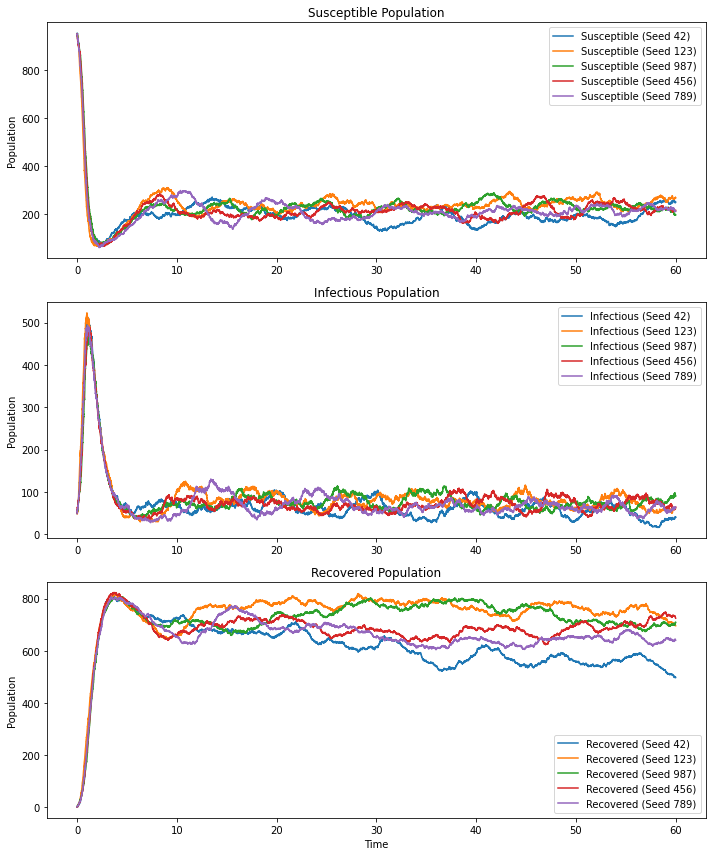

In [7]:
for seed in random_seeds:
    time_series, X_series, Y_series, Z_series = run_sir_simulation(beta, gamma, mu, N, infected_init, recovered_init, max_time, random_seed=seed)
    simulation_results.append((time_series, X_series, Y_series, Z_series))

# Create subplots for infected, susceptible, and recovered
fig, axes = plt.subplots(3, 1, figsize=(10, 12))

# Plot the results for different random seeds
for i, seed in enumerate(random_seeds):
    axes[0].plot(simulation_results[i][0], simulation_results[i][1], label=f'Susceptible (Seed {seed})')
    axes[1].plot(simulation_results[i][0], simulation_results[i][2], label=f'Infectious (Seed {seed})')
    axes[2].plot(simulation_results[i][0], simulation_results[i][3], label=f'Recovered (Seed {seed})')

# Set titles and labels for each subplot
axes[0].set_title('Susceptible Population')
axes[0].set_ylabel('Population')
axes[0].legend()

axes[1].set_title('Infectious Population')
axes[1].set_ylabel('Population')
axes[1].legend()

axes[2].set_title('Recovered Population')
axes[2].set_xlabel('Time')
axes[2].set_ylabel('Population')
axes[2].legend()

plt.tight_layout()
plt.show()

# Variability

In [8]:
# Define the deterministic SIR model
def SIR_model(y, t, beta, gamma, mu, N):
    S, I, R = y
    dSdt = mu * N - beta * S * I / N - mu * S
    dIdt = beta * S * I / N - mu * I - gamma * I
    dRdt = gamma * I - mu * R
    return [dSdt, dIdt, dRdt]

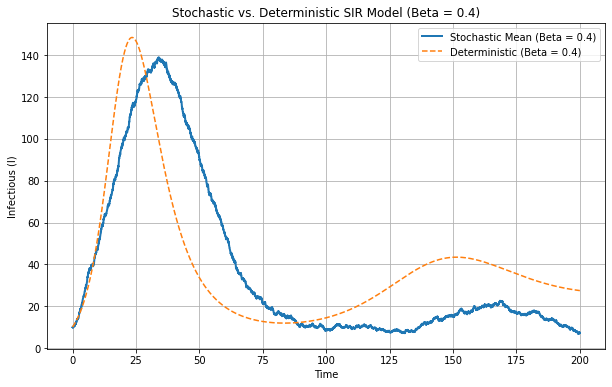

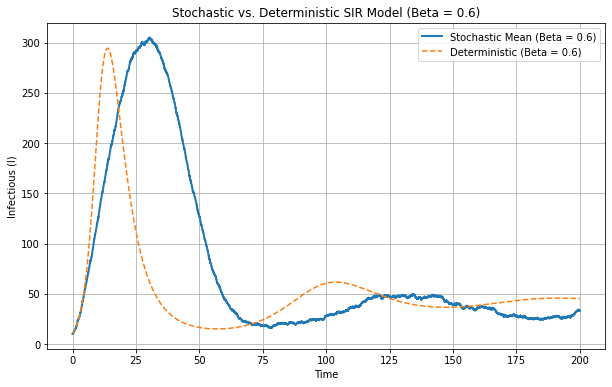

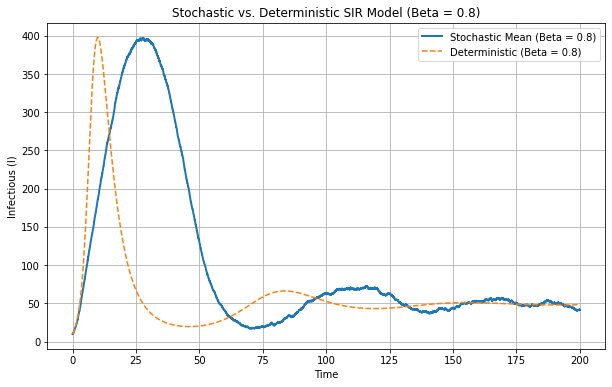

In [9]:


# Define parameters
beta_values = [0.4, 0.6, 0.8]  # Example beta values
gamma = 0.2
mu = 1/70
N = 1000
infected_init = 10
S0 = N - infected_init
recovered_init = 0
t = np.linspace(0, 200, 10000)

# Storage for results
mean_stochastic_I = []

# Loop over beta values
for beta in beta_values:
    # Generate stochastic realizations
    num_simulations = 10
    stochastic_I_realizations = []

    for _ in range(num_simulations):
        # Initialize compartments
        X = N - infected_init - recovered_init
        Y = infected_init
        Z = recovered_init

        # Initialize lists to store population values
        X_values = [X]
        Y_values = [Y]
        Z_values = [Z]

        # Time increment
        dt = t[1] - t[0]

        for _ in range(1, len(t)):
            # Calculate rates
            rates = [
                mu * N,                           # Birth rate
                beta * X * Y / N,                 # Infection rate
                gamma * Y,                        # Recovery rate
                mu * X,                           # Death rate for susceptible
                mu * Y,                           # Death rate for infected
                mu * Z                            # Death rate for recovered
            ]

            # Calculate total rate
            total_rate = sum(rates)

            # Calculate time until the next event
            time_until_event = np.random.exponential(1 / total_rate)

            # Choose the event that happens next
            event = np.random.choice(6, p=[rates[i] / total_rate for i in range(6)])

            # Update compartments based on the chosen event
            if event == 0:
                X += 1
            elif event == 1:
                X -= 1
                Y += 1
            elif event == 2:
                Y -= 1
                Z += 1
            elif event == 3:
                X -= 1
            elif event == 4:
                Y -= 1
            else:
                Z -= 1

            # Append the updated values to the lists
            X_values.append(X)
            Y_values.append(Y)
            Z_values.append(Z)

        # Append the results of a single stochastic realization to the list
        stochastic_I_realizations.append(Y_values)

    # Calculate the mean of stochastic realizations
    mean_I = np.mean(stochastic_I_realizations, axis=0)
    mean_stochastic_I.append(mean_I)

    # Integrate the deterministic SIR model for comparison
    sol = odeint(SIR_model, [S0, infected_init, recovered_init], t, args=(beta, gamma, mu, N))
    deterministic_I = sol[:, 1]

    # Plot individual stochastic realizations, the mean, and deterministic SIR model
    plt.figure(figsize=(10, 6))
#     for i in range(num_simulations):
#         plt.plot(t, stochastic_I_realizations[i], label=f'Stochastic Realization {i + 1}', alpha=0.5)
    plt.plot(t, mean_I, label=f'Stochastic Mean (Beta = {beta})', linestyle='-', linewidth=2)
    plt.plot(t, deterministic_I, label=f'Deterministic (Beta = {beta})', linestyle='--')

    plt.xlabel('Time')
    plt.ylabel('Infectious (I)')
    plt.title(f'Stochastic vs. Deterministic SIR Model (Beta = {beta})')
    plt.legend()
    plt.grid(True)
    plt.show()


# Covariance:

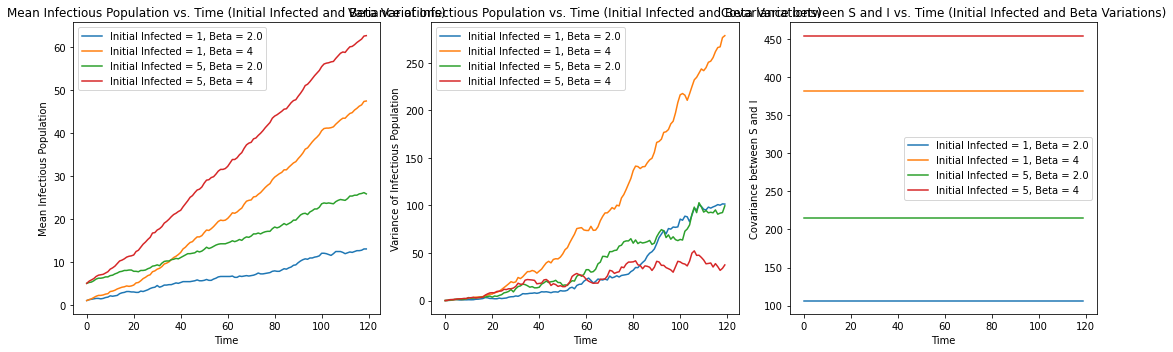

In [11]:
# Function to calculate covariance between S and I
def calculate_covariance(S_series, I_series):
    return np.cov(S_series, I_series)[0, 1]

# Define parameter ranges to explore
beta_values = [2, 4]  # Example beta values
gamma = 1 # Fixed gamma value
mu = 1/70 # Fixed mu value

# Define initial infected values to explore
initial_infected_values = [1, 5]  # Example initial infected values

# Other simulation settings
N = 1000
recovered_init = 1
max_time = 120
num_simulations = 10  # Number of stochastic simulations for each parameter combination

# Storage for results
parameter_settings = []

mean_infectious_populations = []
variances = []
covariances = []

# Loop over initial infected values
for infected_init in initial_infected_values:
    # Loop over beta values
    for beta in beta_values:
        # Store current parameter combination
        parameter_settings.append({"beta": beta, "gamma": gamma, "mu": mu, "infected_init": infected_init})

        # Arrays to store simulation results
        infectious_populations = np.zeros((num_simulations, max_time))
        susceptible_populations = np.zeros((num_simulations, max_time))

        # Run multiple simulations for the current parameter combination
        for i in range(num_simulations):
            time_series, X_series, Y_series, Z_series = run_sir_simulation(
                beta, gamma, mu, N, infected_init, recovered_init, max_time, random_seed=i
            )

            # Truncate the series to match max_time
            time_series = time_series[:max_time]
            X_series = X_series[:max_time]
            Y_series = Y_series[:max_time]
            Z_series = Z_series[:max_time]

            # Store infectious and susceptible populations over time
            infectious_populations[i, :len(Y_series)] = Y_series
            susceptible_populations[i, :len(X_series)] = X_series

        # Calculate statistics for the current parameter combination
        mean_infectious = np.mean(infectious_populations, axis=0)
        var_infectious = np.var(infectious_populations, axis=0)
        covariance_si = calculate_covariance(susceptible_populations, infectious_populations)

        # Store results
        mean_infectious_populations.append(mean_infectious)
        variances.append(var_infectious)
        covariances.append(covariance_si)

# Visualization
plt.figure(figsize=(15, 5))

# Plot mean infectious populations for different initial infected and beta values
plt.subplot(1, 3, 1)
for i, infected_init in enumerate(initial_infected_values):
    for j, beta in enumerate(beta_values):
        label = f'Initial Infected = {infected_init}, Beta = {beta}'
        plt.plot(range(max_time), mean_infectious_populations[i * len(beta_values) + j], label=label)
plt.xlabel('Time')
plt.ylabel('Mean Infectious Population')
plt.title('Mean Infectious Population vs. Time (Initial Infected and Beta Variations)')
plt.legend()

# Plot variances of infectious populations for different initial infected and beta values
plt.subplot(1, 3, 2)
for i, infected_init in enumerate(initial_infected_values):
    for j, beta in enumerate(beta_values):
        label = f'Initial Infected = {infected_init}, Beta = {beta}'
        plt.plot(range(max_time), variances[i * len(beta_values) + j], label=label)
plt.xlabel('Time')
plt.ylabel('Variance of Infectious Population')
plt.title('Variance of Infectious Population vs. Time (Initial Infected and Beta Variations)')
plt.legend()

# Plot covariances between susceptible and infectious populations for different initial infected and beta values
plt.subplot(1, 3, 3)
for i, infected_init in enumerate(initial_infected_values):
    for j, beta in enumerate(beta_values):
        label = f'Initial Infected = {infected_init}, Beta = {beta}'
        plt.plot(range(max_time), [covariances[i * len(beta_values) + j]] * max_time, label=label)
plt.xlabel('Time')
plt.ylabel('Covariance between S and I')
plt.title('Covariance between S and I vs. Time (Initial Infected and Beta Variations)')
plt.legend()

plt.tight_layout()
plt.show()


# Stochastic Resonance

# Increased Transients

# Extinction events 

In [12]:
def run_sir_simulation(beta, gamma, mu, N, infected_init, recovered_init, max_time=60, random_seed=None):

    if random_seed is not None:
        random.seed(random_seed)
        np.random.seed(random_seed)
        
    # Initialize compartments
    X = N - infected_init - recovered_init
    Y = infected_init
    Z = recovered_init

    # Define events
    def Birth(X):
        X += 1
        return X

    def GetInfected(X, Y):
        Y += 1
        X -= 1
        return X, Y

    def Recover(Y, Z):
        Y -= 1
        Z += 1
        return Y, Z

    def DieSusceptible(X):
        X -= 1
        return X

    def DieInfected(Y):
        Y -= 1
        return Y

    def DieRecovered(Z):
        Z -= 1
        return Z

    # Define event chance
    def GetNextEventTime(event_rate):
        delta_t = (-1 / event_rate) * (np.log(random.uniform(0, 1)))
        return delta_t

    def GetRates(X, Y, Z, N, beta, gamma, mu):
        birth_rate = mu * N
        transmission_rate = beta * ((X * Y) / N)
        recovery_rate = gamma * Y
        X_death_rate = mu * X
        Y_death_rate = mu * Y
        Z_death_rate = mu * Z
        return [birth_rate, transmission_rate, recovery_rate, X_death_rate, Y_death_rate, Z_death_rate]

    # Initialize simulation
    data = []
    time = 0
    ext_timelist = []  # Initialize the list to track extinction times

    while time < max_time:
        rates = GetRates(X, Y, Z, N, beta, gamma, mu)

        # Store data
        data.append([time, X, Y, Z])
        next_event_times = []

        # Check for extinction
        if (X <= 0) or (Y <= 0) or (Z <= 0):
            extinction_time = time
            ext_timelist.append(extinction_time)  # Track extinction time
            break

        for rate in rates:
            next_event_times.append(GetNextEventTime(rate))

        next_event_time = min(next_event_times)
        index_next_event = next_event_times.index(next_event_time)

        time += next_event_time

        # Choose event to execute according to minimal delta_t
        if index_next_event == 0:
            X = Birth(X)
        elif index_next_event == 1:
            X, Y = GetInfected(X, Y)
        elif index_next_event == 2:
            Y, Z = Recover(Y, Z)
        elif index_next_event == 3:
            X = DieSusceptible(X)
        elif index_next_event == 4:
            Y = DieInfected(Y)
        else:
            Z = DieRecovered(Z)

        N = X + Y + Z  # Update N

    # Check if an extinction event occurred
    if ext_timelist:
        print(f"Extinction(s) occurred at time(s): {ext_timelist}")

    # Extract data
    time_series = [entry[0] for entry in data]
    X_series = [entry[1] for entry in data]
    Y_series = [entry[2] for entry in data]
    Z_series = [entry[3] for entry in data]

    return time_series, X_series, Y_series, Z_series, ext_timelist


Running simulation for beta = 2
Extinction(s) occurred at time(s): [16.06286452609137]


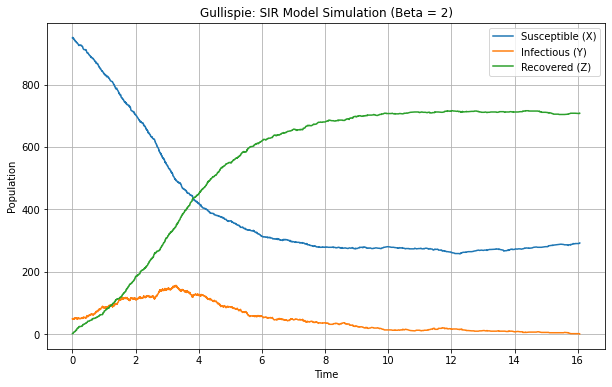

Extinctions for beta = 2 occurred at days: [16.06286452609137]
Running simulation for beta = 3
Extinction(s) occurred at time(s): [9.892955110825067]


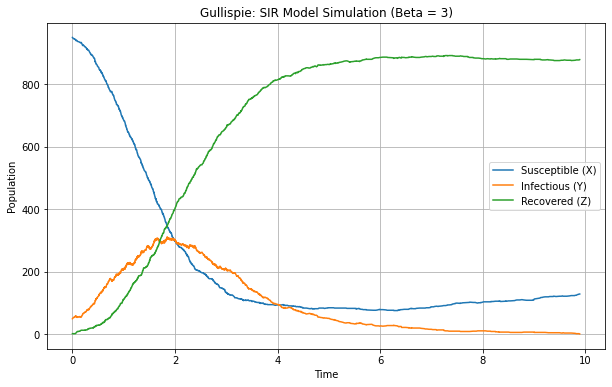

Extinctions for beta = 3 occurred at days: [9.892955110825067]
Running simulation for beta = 4
Extinction(s) occurred at time(s): [12.056524597008464]


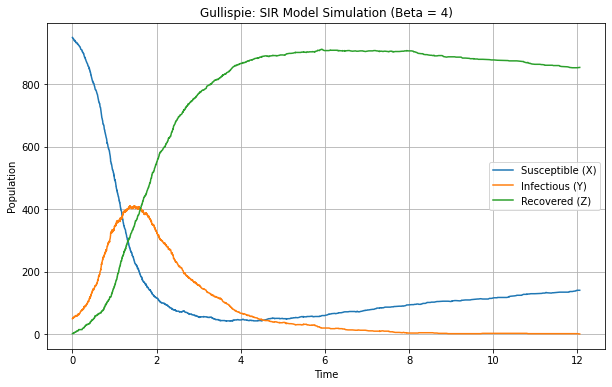

Extinctions for beta = 4 occurred at days: [12.056524597008464]
Running simulation for beta = 5
Extinction(s) occurred at time(s): [13.379009396221301]


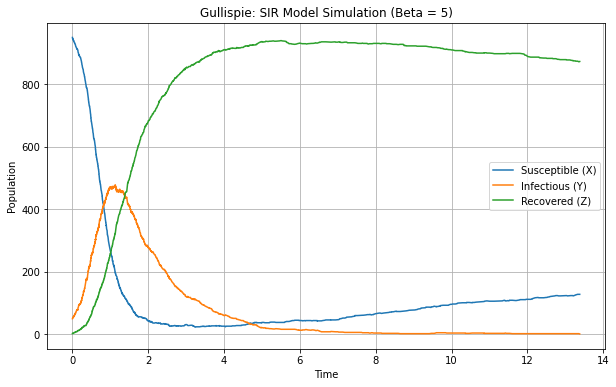

Extinctions for beta = 5 occurred at days: [13.379009396221301]
Running simulation for beta = 6
Extinction(s) occurred at time(s): [8.204523738513858]


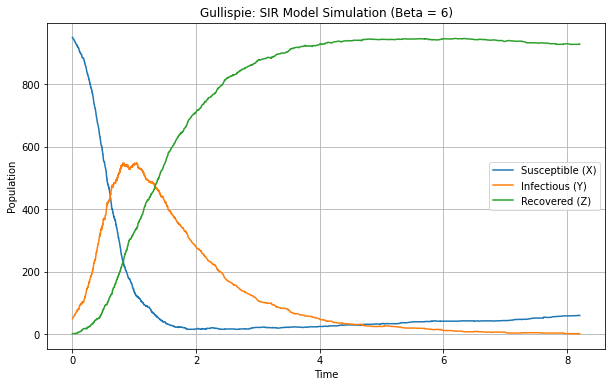

Extinctions for beta = 6 occurred at days: [8.204523738513858]


In [13]:
# Parameters
gamma = 1
mu = 1/70
N = 1000
infected_init = 49
recovered_init = 1
max_time = 190

# Varying values of beta
beta_values = [2, 3, 4, 5, 6]  # Example beta values to vary

# Loop over different beta values
for beta in beta_values:
    extinction_times = []  # Reset the extinction times list
    print(f"Running simulation for beta = {beta}")
    time_series, X_series, Y_series, Z_series, extinction_times = run_sir_simulation(
        beta, gamma, mu, N, infected_init, recovered_init, max_time
    )
    
    # Example: Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(time_series, X_series, label='Susceptible (X)')
    plt.plot(time_series, Y_series, label='Infectious (Y)')
    plt.plot(time_series, Z_series, label='Recovered (Z)')
    plt.xlabel('Time')
    plt.ylabel('Population')
    plt.title(f'Gullispie: SIR Model Simulation (Beta = {beta})')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print timestamps of extinctions
    print(f"Extinctions for beta = {beta} occurred at days: {extinction_times}")

# Critical Community Size